In [2]:
import torch
batch_size = 64
epochs = 100
device = torch.device("cuda:0")
bs_list = [1000, 3000, 5000, 7000, 9000, 11000, 13000, 15000, 17000]

In [3]:
import torchvision
import torchvision.transforms as transforms
import torch
from cnn_mnist import *
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader


class FashionDataset(Dataset):    
    def __init__(self, data, scores_data=None, indices=None, transform = transforms.Compose([transforms.ToTensor()])):
        if indices is None:
            self.fashion_MNIST = data.values
            self.scores_data = scores_data
        else:
            self.fashion_MNIST = data.values[indices]
            self.scores_data = scores_data[indices] if scores_data is not None else None
            
        self.transform = transform
        
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
            label.append(i[0])
            image.append(i[1:])
        self.targets = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):

            
        label = self.targets[index]
        image = self.images[index]
        image = self.transform(image)
        
        if self.scores_data is not None:
            return image, label, self.scores_data[index]
        return image, label

    def __len__(self):
        return len(self.images)

trainset_csv = pd.read_csv("fashion-mnist_train.csv")
testset_csv = pd.read_csv("fashion-mnist_test.csv")

testset = FashionDataset(testset_csv)
#trainset = FashionDataset(trainset)

testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

In [4]:
import numpy as np
# Уберем сложные примеры
scores = torch.Tensor(np.load('values.npy'))
complex_idx = np.where(scores > 0.)[0]

#trainset = torch.utils.data.Subset(trainset, complex_idx)
#trainset.values = trainset.values[complex_idx]
trainset = FashionDataset(trainset_csv, indices = complex_idx)
#trainset.images = trainset.images[complex_idx]
#trainset.targets = trainset.targets[complex_idx]
#trainset.indices = trainset.indices[complex_idx]

In [5]:
import torch.nn as nn

class Loss(object):
    '''
    Class for counting loss
    '''

    def __init__(self, scores = None, is_adaptive = False, adaptive_type = 'mean'):
        self.scores = scores
        self.is_adaptive = is_adaptive
        self.adaptive_type = adaptive_type
        self.alpha = 0.8
        self.max_T = 200
        self.min_T = 1
        if scores is not None:
            self.max_index = self.scores.max().cpu()      
        
    def get_T(self, data_scores):
        max_T = self.max_T
        min_T = self.min_T
        
        if self.is_adaptive :
            T = (max_T - min_T) / self.max_index * data_scores.cpu()
            if self.adaptive_type == 'mean':
                return T.mean().int()
            if self.adaptive_type == 'full':
                return T.int()
            if self.adaptive_type == 'max':
                return T.max().int()
        return torch.Tensor([29])
    
    
    def calculate_loss(self, outputs, labels, teacher_output = None, data_scores = None, device = torch.device("cuda:0")):
        if self.scores is None:
            return nn.CrossEntropyLoss()(outputs, labels)
        else :
            T = self.get_T(data_scores).int()
            if self.adaptive_type == 'full' :
                T = torch.unsqueeze(T, dim = 1)
            T[T < self.min_T] = self.min_T
            T = T.to(device)

            #T_mean = T_mean.to(device)
            
            T.requires_grad = False
            #T_mean.requires_grad = False
            
            model_output = outputs / T
            teacher_output = teacher_output / T
            KD_loss = (nn.KLDivLoss(reduction = 'none')(F.log_softmax( outputs / T, dim=1),F.softmax(teacher_output / T, dim=1))* (self.alpha* T * T)).mean() + \
            F.cross_entropy(outputs, labels) * (1. - self.alpha)
            return KD_loss
        
    

In [6]:
import numpy as np
import torch.optim as optim
from IPython.display import clear_output
import matplotlib.pyplot as plt

def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def test(model, test_loader, device):
    acc = 0
    for x, labels in test_loader:
        x, labels = x.to(device), labels.to(device)
        outputs = model(x)
        pred = outputs.argmax(dim=1, keepdim=True) 
        acc += pred.eq(labels.view_as(pred)).sum().item()
    acc = acc / len(test_loader.dataset)
    
    return acc

def train_and_validate(model, train_loader, test_loader, epochs, device):
    model.train()
    lr = 0.01
    optimizer = optim.SGD(model.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    
    loss_per_epoch_list = []
    loss_function = Loss()
    
    for epoch in range(epochs):
        loss_list = []    
            
        for x, labels in train_loader:
            x, labels = x.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(x)
            loss = loss_function.calculate_loss(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
    
        loss_per_epoch_list.append(np.mean(loss_list))
        scheduler.step()
        
        if epoch > 0 and epoch % 20 == 0:
            clear_output(wait=True)
            plt.plot(loss_per_epoch_list)
            plt.show()
        
    return loss_per_epoch_list, test(model, test_loader, device)
    
            
        
def train_and_validate_with_teacher_and_scores(model, teacher, scores, train_loader, test_loader, epochs, device, is_adaptive = True, adaptive_type = 'mean', max_score = None):
    model.train()
    lr = 0.01
    optimizer = optim.SGD(model.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    
    loss_per_epoch_list = []
    loss_function = Loss(scores = scores, is_adaptive = is_adaptive, adaptive_type = adaptive_type)
    
    for epoch in range(epochs):
        loss_list = []          
            
        for x, labels, score in train_loader:
            if max_score is not None:
                score[score > max_score] = int((max_score / 2))
            x, labels = x.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(x)
            
            teacher_output = teacher(x)
            loss = loss_function.calculate_loss(outputs, labels, teacher_output, score).cpu()
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
    
        loss_per_epoch_list.append(np.mean(loss_list))
        scheduler.step()
        
        if epoch > 0 and epoch % 20 == 0:
            clear_output(wait=True)
            plt.plot(loss_per_epoch_list)
            plt.title(adaptive_type if is_adaptive else 'const' )
            plt.show()
        
    return loss_per_epoch_list, test(model, test_loader, device)

## Train simple model

train teacher

In [7]:
#model = FashionCNN()
#torch.save(model.state_dict(), 'FashionCNN_student.pt')

In [8]:
# train teacher
#model = FashionCNN()
#model.to(device)
#model.train()
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
#loss, acc = train_and_validate(model, trainloader, testloader, epochs, device)
#torch.save(model.state_dict(), 'FashionCNN_teacher.pt')

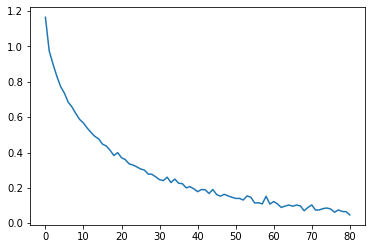

In [9]:
teacher_loss_list = []
teacher_acc_list  = []
for bs in bs_list:
    model = FashionCNN()
    model.load_state_dict(torch.load('FashionCNN_student.pt'))
    model.to(device)
    model.train()
    
    random_indexes = np.random.choice(complex_idx, size=bs, replace=False)
    indexData =  FashionDataset(trainset_csv,indices = random_indexes)
    trainloader = torch.utils.data.DataLoader(indexData, batch_size=batch_size, shuffle=True)
    
    loss_per_epoch_list, acc = train_and_validate(model, trainloader, testloader, epochs, device)
    teacher_loss_list.append(loss_per_epoch_list[-1])
    teacher_acc_list.append(acc)

#torch.save(model.state_dict(), 'ResNet18_teacher.pt')

## Train with teacher and scores

In [10]:
import numpy as np

scores = torch.Tensor(np.load('values.npy')).to(device)

teacher = FashionCNN()
teacher.load_state_dict(torch.load(f'FashionCNN_teacher_reduced_dataset.pt')) 
teacher.to(device)
teacher.eval()
freeze_model(teacher)
test(teacher, testloader, device)

0.9

In [11]:
from torch.utils.data import Dataset, DataLoader

class IndexData(Dataset):
    def __init__(self, dataset, scores_data, indices=None):
        self.data = dataset
        self.indices = (
            indices if indices is not None else np.arange(len(dataset))
        )
        self.scores_data = scores_data

    def __getitem__(self, index):
        index = self.indices[index]
        data, target = self.data[index]
        return data, target, self.scores_data[index]

    def __len__(self):
        return len(self.indices)

In [12]:
def train_with_idx(indexes, adaptive_type):
    
    model = FashionCNN()
    model.load_state_dict(torch.load('FashionCNN_student.pt'))
    model.to(device)
    model.train()
    
    indexData =  FashionDataset(trainset_csv, scores_data = scores,indices = indexes)
    trainloader = torch.utils.data.DataLoader(indexData, batch_size=batch_size, shuffle=True)
    
    loss, acc = train_and_validate_with_teacher_and_scores(model, teacher, scores, trainloader, testloader, epochs, device, is_adaptive = True, adaptive_type = adaptive_type)
    return loss, acc

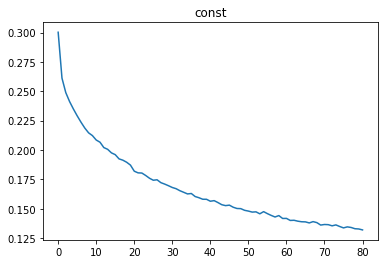

In [13]:
average_acc_list = {}
average_loss_list = {}

average_acc_list['mean'] = []
average_loss_list['mean'] = []

average_acc_list['full'] = []
average_loss_list['full'] = []

average_acc_list['const_mean'] = []
average_loss_list['const_mean'] = []


num_repeat = 3

for bs in bs_list:
    print(bs)
    acc_list = {}
    loss_list = {}

    acc_list['mean'] = []
    loss_list['mean'] = []
    
    acc_list['full'] = []
    loss_list['full'] = []
    
    acc_list['const_mean'] = []
    loss_list['const_mean'] = []
    
    for i in range(num_repeat):
        indexes = np.random.choice(complex_idx, size=bs, replace=False)
        
        # считаем для каждого объекта свою температуру
        adaptive_type = 'full'
        loss, acc = train_with_idx(indexes, adaptive_type)
        acc_list[adaptive_type].append(acc)
        loss_list[adaptive_type].append(loss[-1])
        
    
        # берем температуру как среднее
        adaptive_type = 'mean'
        loss, acc = train_with_idx(indexes, adaptive_type)
        acc_list[adaptive_type].append(acc)
        loss_list[adaptive_type].append(loss[-1])
        
        # не меняем температуру
        adaptive_type = 'const'
        loss, acc = train_with_idx(indexes, adaptive_type)
        acc_list['const_mean'].append(acc)
        loss_list['const_mean'].append(loss[-1])
        
    average_acc_list['mean'].append(np.mean(acc_list['mean']))
    average_loss_list['mean'].append(np.mean(loss_list['mean']))
    
    average_acc_list['full'].append(np.mean(acc_list['full']))
    average_loss_list['full'].append(np.mean(loss_list['full']))
    
    average_acc_list['const_mean'].append(np.mean(acc_list['const_mean']))
    average_loss_list['const_mean'].append(np.mean(loss_list['const_mean']))



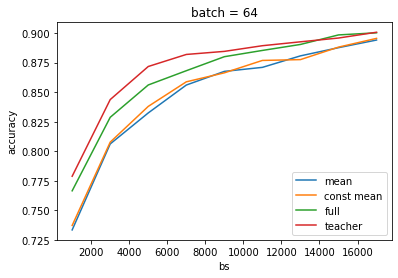

In [16]:
plt.plot(bs_list, average_acc_list['mean'], label = 'mean')
plt.plot(bs_list, average_acc_list['const_mean'], label = 'const mean')
#plt.plot(bs_list, acc_list['const_mean'], label = 'const mean')
#plt.plot(bs_list, acc_list['const_100'], label = 'const 100')
plt.plot(bs_list, average_acc_list['full'], label = 'full')
#plt.plot(bs_list, acc_list['new_full_2'], label = 'full contrary 2')
plt.plot(bs_list, teacher_acc_list, label = 'teacher')

plt.title(f'batch = {batch_size}')
plt.legend()
plt.xlabel('bs')
plt.ylabel('accuracy')
plt.show()